# Boise River discharge statistics (1971 through 2017)
## Values are daily averages
    - Dickey-Fuller test (assessing stationarity)
    - Moving Average model (1 year centered)
    - Mann-Kendall trend analysis on trends

## Setup data

In [122]:
from __future__ import division
from scipy.stats import norm, mstats
import pandas as pd
import numpy as np
from scipy.special import ndtri, ndtr
import sys
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import close
from pandas.core import datetools as dt
import statsmodels.tsa.api as sm
from scipy import stats
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# read in and initialize
df = pd.read_csv('boiseriverDischarge.csv', names=['Dates','Year','Month','Day','Parma','Lucky'], skiprows=1)
parma = df['Parma'].values
lucky = df['Lucky'].values
df['Date'] = pd.to_datetime(df.Year*10000+df.Month*100+df.Day,format='%Y%m%d')
dates = df['Date']
days = df['Date'].dt.day
seriesLucky = pd.Series(lucky,index=dates)
seriesParma = pd.Series(parma,index=dates)
# Year window of interest
N = 1
# Decomposition of the data based on N years
years = N*365

## Test data for stationarity
The data needs to meet stationarity requirements in order to run further data analysis. In the case of the Dickey-Fuller test, the Critical Values larger than the Test Statistic and a P-Value smaller than 0.05 indicate the data is stationary.

In [98]:
# Lucky Peak Dickey Fuller test
print ('Results of Dickey-Fuller Test for Lucky Peak Discharge:')
dftest = adfuller(seriesLucky, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
# Parma Dickey Fuller test
print ('Results of Dickey-Fuller Test for Parma Discharge:')
dftest = adfuller(seriesParma, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
print('\033[1m --Data is stationary--')

Results of Dickey-Fuller Test for Lucky Peak Discharge:
Test Statistic                -1.257271e+01
p-value                        1.987961e-23
#Lags Used                     4.300000e+01
Number of Observations Used    1.675800e+04
Critical Value (1%)           -3.430740e+00
Critical Value (5%)           -2.861712e+00
Critical Value (10%)          -2.566862e+00
dtype: float64
Results of Dickey-Fuller Test for Parma Discharge:
Test Statistic                -1.015807e+01
p-value                        7.635790e-18
#Lags Used                     3.800000e+01
Number of Observations Used    1.676300e+04
Critical Value (1%)           -3.430740e+00
Critical Value (5%)           -2.861712e+00
Critical Value (10%)          -2.566862e+00
dtype: float64
 --Data is stationary--


## Visualize data components

Decomposition of Lucky Peak Discharge


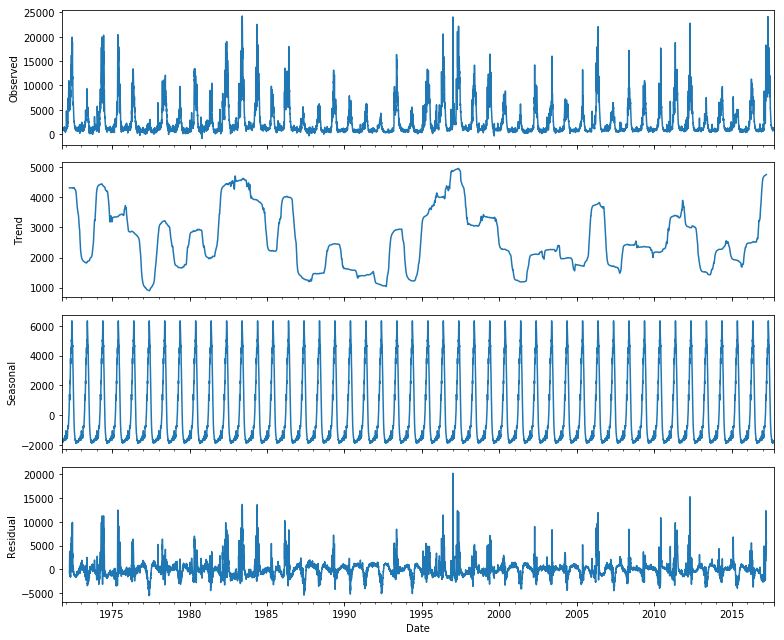

Decomposition of Parma Discharge


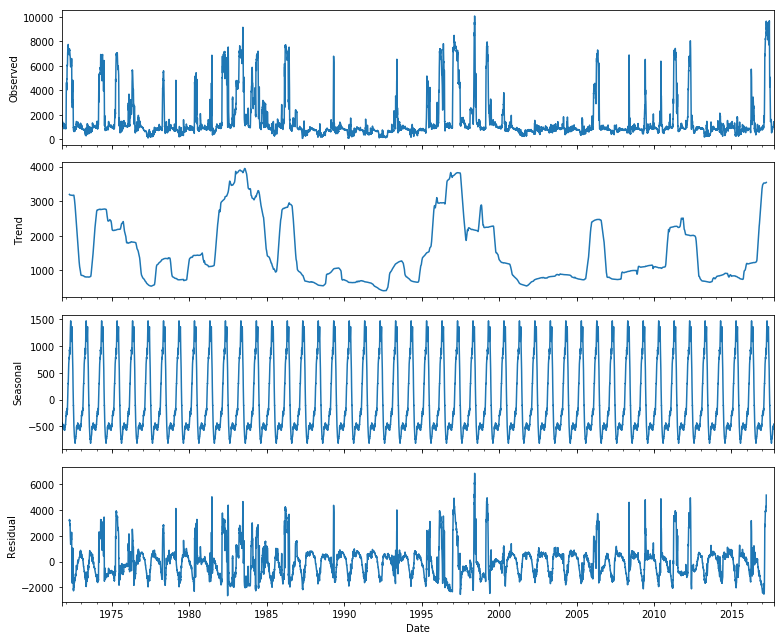

In [127]:
# Decomposition of the data based on N years
years = N*365
decompositionLucky = sm.seasonal_decompose(seriesLucky, model='additive',freq=years)
decompositionParma = sm.seasonal_decompose(seriesParma, model='additive',freq=years)
# Lucky Peak
# Decomposition
rcParams['figure.figsize'] = 11, 9
print('Decomposition of Lucky Peak Discharge')
fig = decompositionLucky.plot()
plt.show()
# Parma
# Decomposition
rcParams['figure.figsize'] = 11, 9
print('Decomposition of Parma Discharge')
fig2 = decompositionParma.plot()
plt.show()

## Calculate Moving Average of both Lucky Peak and Parma Discharge, and plot

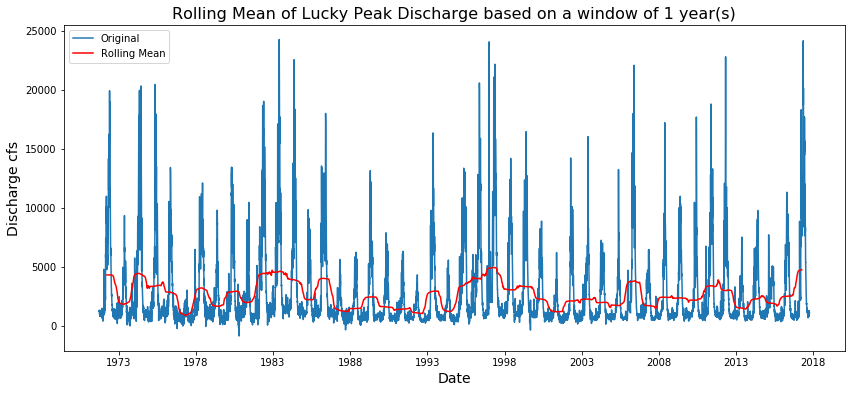

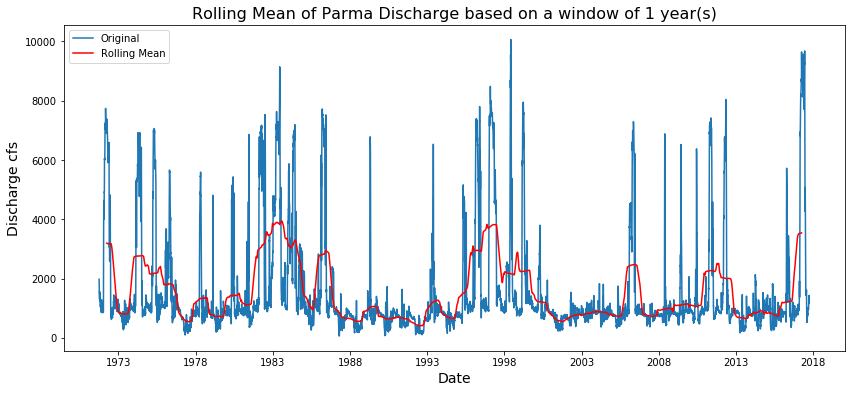

In [100]:
#variables for moving averages
rolmean_lucky = pd.rolling_mean(seriesLucky, window=years, center=True)
rolstd_lucky = pd.rolling_std(seriesLucky, window=years, center=True)
rolmean_parma = pd.rolling_mean(seriesParma, window=years, center=True)
rolstd_parma = pd.rolling_std(seriesParma, window=years, center=True)
RM_Lucky = pd.rolling_mean(seriesLucky, window=years, center=True).values
RM_Parma = pd.rolling_mean(seriesParma, window=years, center=True).values
# Plot Lucky Peak
plt.figure(figsize=(14,6))
orig = plt.plot(seriesLucky,label='Original')
mean = plt.plot(rolmean_lucky, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean of Lucky Peak Discharge based on a window of %i year(s)'%N,fontsize=16)
plt.ylabel('Discharge cfs',fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.show()
# Plot Parma
plt.figure(figsize=(14,6))
orig = plt.plot(seriesParma,label='Original')
mean = plt.plot(rolmean_parma, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean of Parma Discharge based on a window of %i year(s)'%N,fontsize=16)
plt.ylabel('Discharge cfs',fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.show()

## Plot new Moving Average's and establish trendlines
The Moving Average model creates NaN values within the original data set; this creates a new series without NaN values

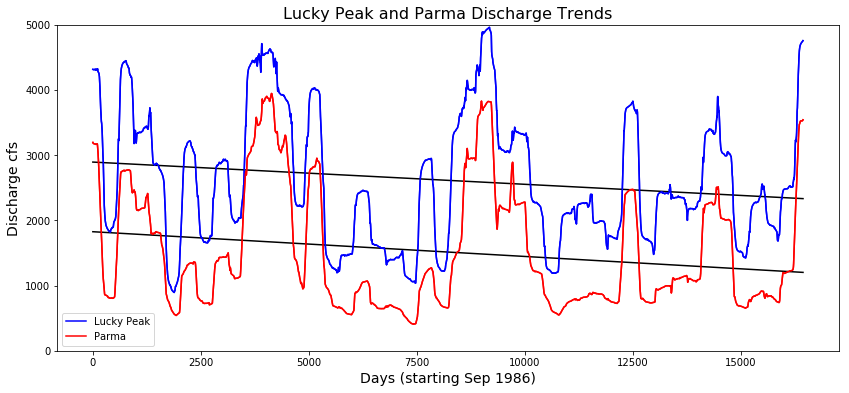

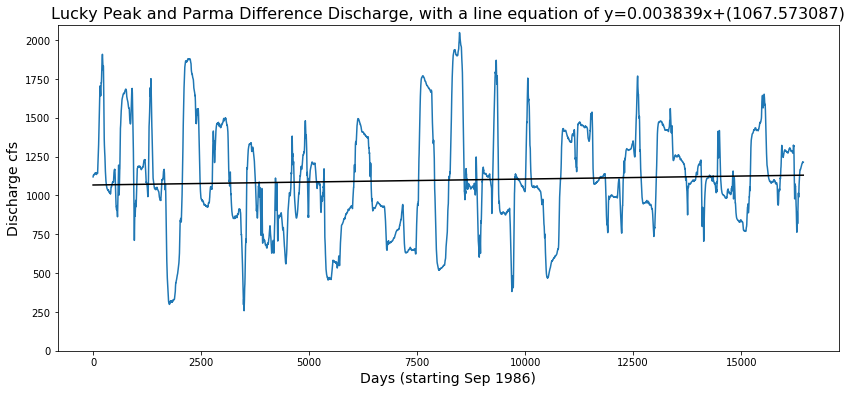

In [123]:
# Plots for data and trends
# Create new dataframe and trim NaN values from the data
df2 = pd.DataFrame({'Date': dates, 'RM_lucky': RM_Lucky, 'RM_Parma': RM_Parma})
filtered_df2 = df2[df2['RM_lucky'].notnull()]
RM_Lucky_f = filtered_df2['RM_lucky'].values
RM_Parma_f = filtered_df2['RM_Parma'].values
date_f = filtered_df2['Date'].values.astype('datetime64[D]')

# Calculate the difference per year between the datasets
# Difference
difference = []
for i in range(len(RM_Lucky_f)):
    x = RM_Lucky_f[i] - RM_Parma_f[i]
    difference.append(x)
difference = np.array(difference)

# trendline psuedo x vector    
daterange = np.arange(0,len(difference),1)

# Plot of both Lucky peak and Parma
# lucky peak trendline
zl = np.polyfit(daterange, RM_Lucky_f, 1)
pl = np.poly1d(zl)
# Parma trendline
zp = np.polyfit(daterange, RM_Parma_f, 1)
pp = np.poly1d(zp)
# Plot
plt.figure(figsize=(14,6))
plt.plot(daterange,RM_Lucky_f,color="blue")
plt.plot(daterange,pl(daterange),color="black")
plt.plot(daterange,RM_Parma_f,color="red")
plt.plot(daterange,pp(daterange),color="black")
orig = plt.plot(RM_Lucky_f,label='Lucky Peak',color="blue")
mean = plt.plot(RM_Parma_f, color='red', label='Parma')
plt.legend(loc='best')
plt.xlabel('Days (starting Sep 1986)',fontsize=14)
plt.title('Lucky Peak and Parma Discharge Trends', fontsize=16)
plt.ylabel('Discharge cfs',fontsize=14)
axes = plt.gca()
axes.set_ylim([0,5000])
plt.show()

# Plot difference of both moving averages
# difference trendline
z = np.polyfit(daterange, difference, 1)
p = np.poly1d(z)
dp = p
plt.figure(figsize=(14,6))
plt.plot(daterange,difference)
plt.plot(daterange,p(daterange),color="black")
plt.title('Lucky Peak and Parma Difference Discharge, with a line equation of y=%.6fx+(%.6f)'%(z[0],z[1]),fontsize=16)
plt.ylabel('Discharge cfs',fontsize=14)
plt.xlabel('Days (starting Sep 1986)',fontsize=14)
axes = plt.gca()
axes.set_ylim([0,2100])
plt.show()

In [136]:
print ('Results of Dickey-Fuller Test for Moving Average Lucky Peak Discharge:')
RM_seriesLucky = pd.Series(RM_Lucky_f,index=date_f)
dftest = adfuller(RM_seriesLucky, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
print ('Results of Dickey-Fuller Test for Moving Average Parma Discharge:')
RM_seriesParma = pd.Series(RM_Parma_f,index=date_f)
dftest = adfuller(RM_seriesParma, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
print ('Results of Dickey-Fuller Test for Moving Average Difference Discharge:')
RM_seriesDifference = pd.Series(difference,index=date_f)
dftest = adfuller(RM_seriesDifference, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test for Moving Average Lucky Peak Discharge:
Test Statistic                    -5.030498
p-value                            0.000019
#Lags Used                        36.000000
Number of Observations Used    16401.000000
Critical Value (1%)               -3.430749
Critical Value (5%)               -2.861716
Critical Value (10%)              -2.566864
dtype: float64
Results of Dickey-Fuller Test for Moving Average Parma Discharge:
Test Statistic                    -4.087652
p-value                            0.001015
#Lags Used                        39.000000
Number of Observations Used    16398.000000
Critical Value (1%)               -3.430749
Critical Value (5%)               -2.861716
Critical Value (10%)              -2.566864
dtype: float64
Results of Dickey-Fuller Test for Moving Average Difference Discharge:
Test Statistic                -7.003003e+00
p-value                        7.240601e-10
#Lags Used                     4.200000e+01
Number of Obse

## Trendline statistics
Statistical analysis can be completed on trendlines to assess actual trend using the Mann-Kendall(M.K) trend test. The M.K. trend test is a nonparametric test used to identify a trend in a series, even if there is a seasonal component in the series. The M.K. tests are based on the calculation of Kendall's tau measure of association between two samples, which is itself based on the ranks with the samples. The computations assume that the observations are independent.
This method is the same used in:
- Clark, Gregory M., 2010. Changes in Patterns of Streamflow From Unregulated Watersheds in Idaho, Western Wyoming, and Northern Nevada. Journal of the American Water Resources Association

### Two different M.K. test models were used on the same difference data. Both provided identical results

In [130]:
def test(t, x, eps=None, alpha=None, Ha=None):
    """
    Runs the Mann-Kendall test for trend in time series data.

    Parameters
    ----------
    t : 1D numpy.ndarray
        array of the time points of measurements
    x : 1D numpy.ndarray
        array containing the measurements corresponding to entries of 't'
    eps : scalar, float, greater than zero
        least count error of measurements which help determine ties in the data
    alpha : scalar, float, greater than zero
        significance level of the statistical test (Type I error)
    Ha : string, options include 'up', 'down', 'upordown'
        type of test: one-sided ('up' or 'down') or two-sided ('updown')

    Returns
    -------
    MK : string
        result of the statistical test indicating whether or not to accept hte
        alternative hypothesis 'Ha'
    m : scalar, float
        slope of the linear fit to the data
    c : scalar, float
        intercept of the linear fit to the data
    p : scalar, float, greater than zero
        p-value of the obtained Z-score statistic for the Mann-Kendall test

    Raises
    ------
    AssertionError : error
                    least count error of measurements 'eps' is not given
    AssertionError : error
                    significance level of test 'alpha' is not given
    AssertionError : error
                    alternative hypothesis 'Ha' is not given

    """
    # assert a least count for the measurements x
    assert eps, "Please provide least count error for measurements 'x'"
    assert alpha, "Please provide significance level 'alpha' for the test"
    assert Ha, "Please provide the alternative hypothesis 'Ha'"

    # estimate sign of all possible (n(n-1)) / 2 differences
    n = len(t)
    sgn = np.zeros((n, n), dtype="int")
    for i in range(n):
        tmp = x - x[i]
        tmp[np.where(np.fabs(tmp) <= eps)] = 0.
        sgn[i] = np.sign(tmp)

    # estimate mean of the sign of all possible differences
    S = sgn[np.triu_indices(n, k=1)].sum()

    # estimate variance of the sign of all possible differences
    # 1. Determine no. of tie groups 'p' and no. of ties in each group 'q'
    np.fill_diagonal(sgn, eps * 1E6)
    i, j = np.where(sgn == 0.)
    ties = np.unique(x[i])
    p = len(ties)
    q = np.zeros(len(ties), dtype="int")
    for k in range(p):
        idx =  np.where(np.fabs(x - ties[k]) < eps)[0]
        q[k] = len(idx)
    # 2. Determine the two terms in the variance calculation
    term1 = n * (n - 1) * (2 * n + 5)
    term2 = (q * (q - 1) * (2 * q + 5)).sum()
    # 3. estimate variance
    varS = float(term1 - term2) / 18.

    # Compute the Z-score based on above estimated mean and variance
    if S > eps:
        Zmk = (S - 1) / np.sqrt(varS)
    elif np.fabs(S) <= eps:
        Zmk = 0.
    elif S < -eps:
        Zmk = (S + 1) / np.sqrt(varS)

    # compute test based on given 'alpha' and alternative hypothesis
    # note: for all the following cases, the null hypothesis Ho is:
    # Ho := there is no monotonic trend
    # 
    # Ha := There is an upward monotonic trend
    if Ha == "up":
        Z_ = ndtri(1. - alpha)
        if Zmk >= Z_:
            MK = "upward trend"
        else:
            MK = "upward trend"
    # Ha := There is a downward monotonic trend
    elif Ha == "down":
        Z_ = ndtri(1. - alpha)
        if Zmk <= -Z_:
            MK = "downward trend"
        else:
            MK = "downward trend"
    # Ha := There is an upward OR downward monotonic trend
    elif Ha == "upordown":
        Z_ = ndtri(1. - alpha / 2.)
        if np.fabs(Zmk) >= Z_:
            MK = "accept Ha := upward OR downward trend"
        else:
            MK = "reject Ha := upward OR downward trend"

    # ----------
    # AS A BONUS
    # ----------
    # estimate the slope and intercept of the line
    m = np.corrcoef(t, x)[0, 1] * (np.std(x) / np.std(t))
    c = np.mean(x) - m * np.mean(t)

    # ----------
    # AS A BONUS
    # ----------
    # estimate the p-value for the obtained Z-score Zmk
    if S > eps:
        if Ha == "up":
            p = 1. - ndtr(Zmk)
        elif Ha == "down":
            p = ndtr(Zmk)
        elif Ha == "upordown":
            p = 0.5 * (1. - ndtr(Zmk))
    elif np.fabs(S) <= eps:
        p = 0.5
    elif S < -eps:
        if Ha == "up":
            p = 1. - ndtr(Zmk)
        elif Ha == "down":
            p = ndtr(Zmk)
        elif Ha == "upordown":
            p = 0.5 * (ndtr(Zmk))
            
    # calculate the p_value
    p2 = 2*(1-norm.cdf(abs(Zmk))) # two tail test
    h = abs(z) > norm.ppf(1-alpha/2) 
    p3 = format(p2, '.8f')

    return MK, m, c, p
    """
    MK : string
        result of the statistical test indicating whether or not to accept hte
        alternative hypothesis 'Ha'
    m : scalar, float
        slope of the linear fit to the data
    c : scalar, float
        intercept of the linear fit to the data
    p : scalar, float, greater than zero
        p-value of the obtained Z-score statistic for the Mann-Kendall test
    """

In [133]:
MK, m, c, p = test(daterange, difference, eps=0.01, alpha=0.05, Ha="up");
print('\033[1m Trend? %s'%MK)
print('\033[1m p-value (<0.5 = trend is significant): %.1f'%p)

 Trend? upward trend
 p-value (<0.5 = trend is significant): 0.0


In [81]:
def mk_test(x, alpha = 0.05):
    """
    This function is derived from code originally posted by Sat Kumar Tomer (satkumartomer at gmail.com)
    See also: http://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm

    The purpose of the Mann-Kendall (MK) test (Mann 1945, Kendall 1975, Gilbert 1987) is to statistically assess if there is a monotonic upward or downward trend of the variable of interest over time. A monotonic upward (downward) trend means that the variable consistently increases (decreases) through time, but the trend may or may not be linear. The MK test can be used in place of a parametric linear regression analysis, which can be used to test if the slope of the estimated linear regression line is different from zero. The regression analysis requires that the residuals from the fitted regression line be normally distributed; an assumption not required by the MK test, that is, the MK test is a non-parametric (distribution-free) test.
    Hirsch, Slack and Smith (1982, page 107) indicate that the MK test is best viewed as an exploratory analysis and is most appropriately used to identify stations where changes are significant or of large magnitude and to quantify these findings.

    Input:
        x:   a vector of data
        alpha: significance level (0.05 default)

    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the significance test
        z: normalized test statistics

    Examples
    --------
      >>> x = np.random.rand(100)
      >>> trend,h,p,z = mk_test(x,0.05)
    """
    n = len(x)

    # calculate S
    s = 0
    for k in range(n-1):
        for j in range(k+1,n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)

    # calculate the var(s)
    if n == g: # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else: # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(unique_x[i] == x)
        var_s = (n*(n-1)*(2*n+5) + np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s>0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
            z = 0
    elif s<0:
        z = (s + 1)/np.sqrt(var_s)

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z))) # two tail test
    p2 = format(p, '.4f')
    h = abs(z) > norm.ppf(1-alpha/2)

    if (z<0) and h:
        trend = 'decreasing'
    elif (z>0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'

    return trend, h, p, z

In [134]:
trend, h, p, z = mk_test(difference, alpha = 0.05)
print('\033[1m Trend? %s'%trend)
print('\033[1m p-value (<0.5 = trend is significant): %.1f'%p)

 Trend? increasing
 p-value (<0.5 = trend is significant): 0.0


## Results
Both M.K. test models show the trend to be increasing within the Difference data. That is to say- there is a small, but increasing trend in the difference of water entering the lower basin system from Lucky Peak, and the water leaving the system at Parma. Or- less and less water is leaving the lower basin system at Parma over time.